<a href="https://colab.research.google.com/github/frh02/ProjectEEG/blob/master/Complete_VGG16_CNN_EEG_epoch_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten,Reshape,Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils.np_utils import to_categorical 
import keras 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline


Using TensorFlow backend.


In [21]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Data_Combined/train'
valid_path = '/content/drive/My Drive/Data_Combined/validation'
test_path = '/content/drive/My Drive/Data_Combined/test'

vgg16_model = VGG16(weights="imagenet", include_top=True)

# (1) visualize layers
print("VGG16 model layers")
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.output_shape)

# (2) remove the top layer
base_model = Model(input=vgg16_model.input, 
                   output=vgg16_model.get_layer("block5_pool").output)

# (3) attach a new top layer
base_out = base_model.output
base_out = Reshape((25088,))(base_out)
top_fc1 = Dropout(0.5)(base_out)
# output layer: (None, 5)
top_preds = Dense(3, activation="softmax")(top_fc1)

# (4) freeze weights until the last but one convolution layer (block4_pool)
for layer in base_model.layers[0:14]:
    layer.trainable = False

# (5) create new hybrid model
model = Model(input=base_model.input, output=top_preds)
model.load_weights('/content/drive/My Drive/Colab Notebooks/CNN_VGG_Weights/new_model_196_0.746.h5')
# (6) compile and train the model
sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

VGG16 model layers
0 input_3 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


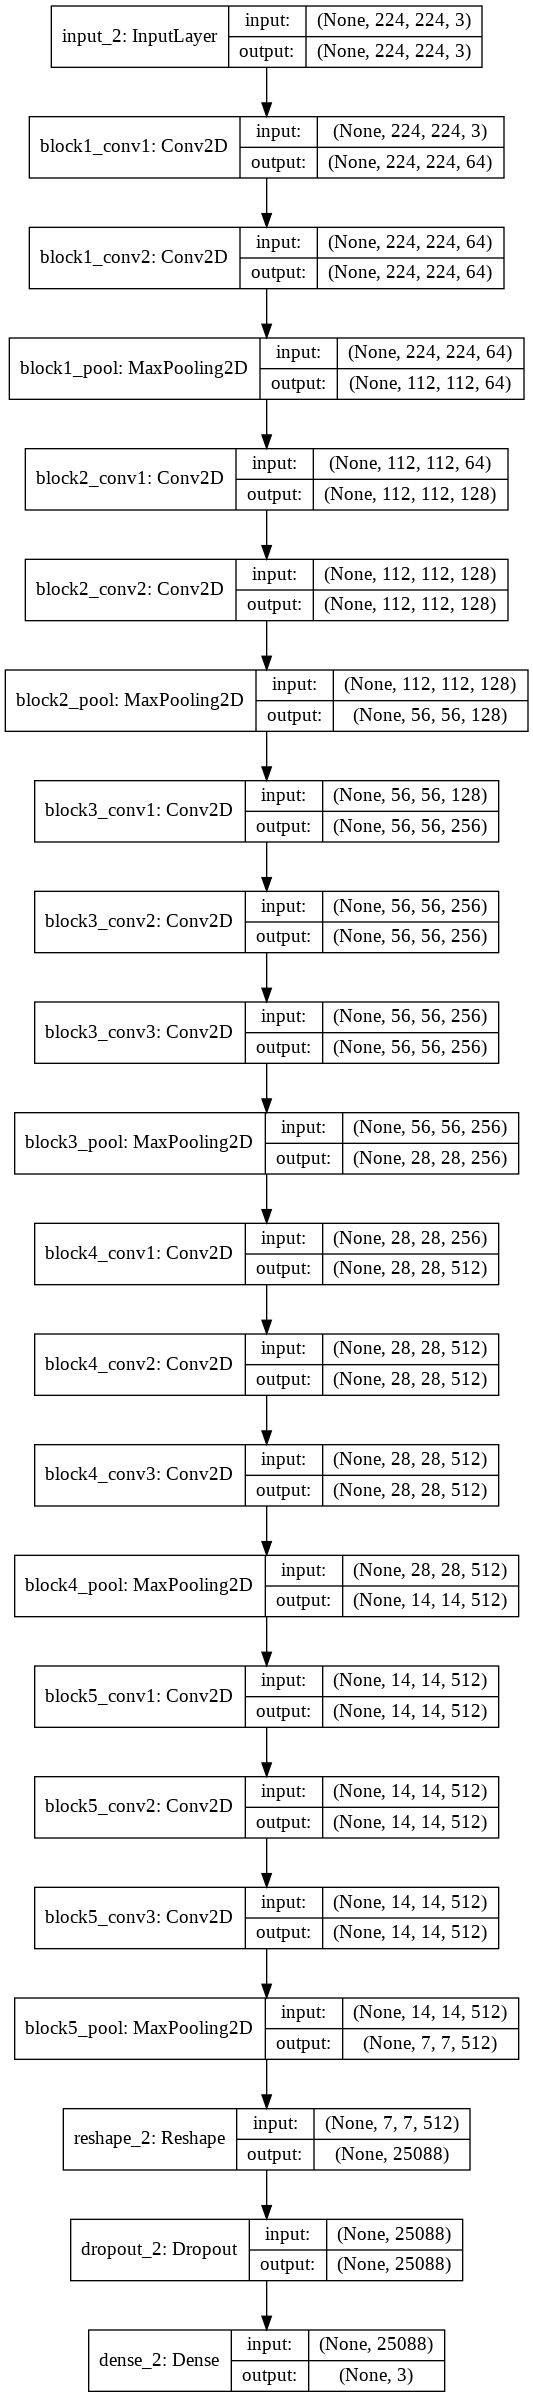

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='vgg_16.png',show_shapes=True, show_layer_names=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [22]:
# view the structure of the model
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
if not os.path.isdir('/content/drive/My Drive/Colab Notebooks/CNN_VGG_Weights'):
    os.mkdir('/content/drive/My Drive/Colab Notebooks/CNN_VGG_Weights')

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale= 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Data_Combined/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 
                                                 class_mode = 'categorical')

nb_train_samples = len(training_set.filenames) 
num_classes = len(training_set.class_indices) 
train_labels = training_set.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_set = valid_datagen.flow_from_directory('/content/drive/My Drive/Data_Combined/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            
                                            class_mode = 'categorical')

nb_valid_samples = len(valid_set.filenames) 
num_classes = len(valid_set.class_indices) 
valid_labels = valid_set.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Data_Combined/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            
                                            class_mode = 'categorical')

nb_train_samples = len(test_set.filenames) 
num_classes = len(test_set.class_indices) 
test_labels = test_set.classes 
test_labels = to_categorical(test_labels, num_classes=num_classes)


Found 7750 images belonging to 3 classes.
Found 2082 images belonging to 3 classes.
Found 1038 images belonging to 3 classes.


In [9]:
from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
r = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=250,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set),
  callbacks=[ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN_VGG_Weights/new_model_{epoch:03d}_{val_accuracy:.3f}.h5', 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_accuracy')
          ],
initial_epoch=200
)

Epoch 201/250
243/243 [==============================] - 203s 837ms/step - loss: 0.5836 - accuracy: 0.7577 - val_loss: 1.0561 - val_accuracy: 0.7152
Epoch 202/250
243/243 [==============================] - 200s 825ms/step - loss: 0.5920 - accuracy: 0.7529 - val_loss: 1.1719 - val_accuracy: 0.6964
Epoch 203/250
243/243 [==============================] - 200s 823ms/step - loss: 0.5885 - accuracy: 0.7572 - val_loss: 0.7043 - val_accuracy: 0.6575
Epoch 204/250
243/243 [==============================] - 197s 811ms/step - loss: 0.6009 - accuracy: 0.7512 - val_loss: 1.3229 - val_accuracy: 0.7056
Epoch 205/250
243/243 [==============================] - 194s 797ms/step - loss: 0.5874 - accuracy: 0.7590 - val_loss: 0.9326 - val_accuracy: 0.6868
Epoch 206/250
243/243 [==============================] - 196s 806ms/step - loss: 0.5823 - accuracy: 0.7618 - val_loss: 5.6365 - val_accuracy: 0.7080
Epoch 207/250
243/243 [==============================] - 203s 834ms/step - loss: 0.5917 - accuracy: 0.7520

In [11]:
#model.load_weights(bestmodel)
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/CNN_VGG_Weights/new_model_196_0.746.h5')

In [12]:
results = model.evaluate(training_set,steps=len(training_set))
print('Train accuracy:', results[1]*100)

243/243 [==============================] - 169s 697ms/step
Train accuracy: 76.06451511383057


In [13]:
results = model.evaluate(test_set,steps=len(test_set))
print('Test accuracy:', results[1]*100)

33/33 [==============================] - 463s 14s/step
Test accuracy: 74.08477663993835


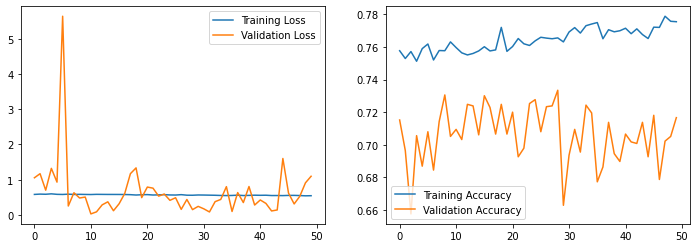

In [26]:
losses = r.history['loss']
accs = r.history['accuracy']
val_losses = r.history['val_loss']
val_accs = r.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [15]:
#training data
from keras.utils.np_utils import to_categorical 
import itertools
nb_train_samples = len(test_set.filenames) 
num_classes = len(test_set.class_indices) 

 
# get the class labels for the training data, in the original order 
test_labels = test_set.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it’s categorical variable
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(test_set,len(test_set),0)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(Y_pred).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title="Confusion matrix",
   cmap=plt.cm.Blues):
 
#Add Normalization Option
   
   
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 


Normalized confusion matrix


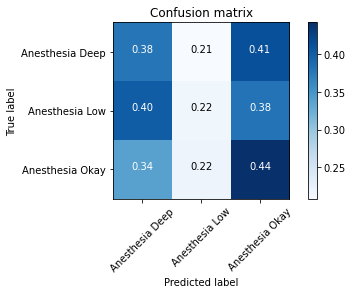

In [19]:
plot_confusion_matrix(confusion_matrix,['Anesthesia Deep', 'Anesthesia Low', 'Anesthesia Okay'],normalize=True)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
  
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_set,len(test_set))
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

print('Classification Report')
target_names = ['Anesthesia Deep', 'Anesthesia Low', 'Anesthesia Okay']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[131  72 143]
 [139  75 132]
 [117  76 153]]
Classification Report
                 precision    recall  f1-score   support

Anesthesia Deep       0.34      0.38      0.36       346
 Anesthesia Low       0.34      0.22      0.26       346
Anesthesia Okay       0.36      0.44      0.40       346

       accuracy                           0.35      1038
      macro avg       0.34      0.35      0.34      1038
   weighted avg       0.34      0.35      0.34      1038

